In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# pandas set up
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 100)

In [2]:
# Veri dosya yolları
DATA_PATH = '../data/'

# Tüm datasetleri yükle
orders = pd.read_csv(DATA_PATH + 'olist_orders_dataset.csv')
order_items = pd.read_csv(DATA_PATH + 'olist_order_items_dataset.csv')
customers = pd.read_csv(DATA_PATH + 'olist_customers_dataset.csv')
payments = pd.read_csv(DATA_PATH + 'olist_order_payments_dataset.csv')
reviews = pd.read_csv(DATA_PATH + 'olist_order_reviews_dataset.csv')
products = pd.read_csv(DATA_PATH + 'olist_products_dataset.csv')


print(f"\nOrders shape: {orders.shape}")
print(f"Customers shape: {customers.shape}")
print(f"Order Items shape: {order_items.shape}")


Orders shape: (99441, 8)
Customers shape: (99441, 5)
Order Items shape: (112650, 7)


In [3]:
# Orders dataset keşfi
print("\n" + "="*80)
print("ORDERS DATASET INFO")
print("="*80)
print(orders.info())
print("\nFirst 5 rows:")
print(orders.head())


ORDERS DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

First 5 rows:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2 

In [4]:
# Sipariş durumlarının dağılımı
print("\n" + "="*80)
print("ORDER STATUS DISTRIBUTION")
print("="*80)
print(orders['order_status'].value_counts())


ORDER STATUS DISTRIBUTION
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


In [6]:
# convert date columns type as date

date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [11]:
print("="*80)
print("Time Range")
print("="*80)
print(f"First Order: {orders['order_purchase_timestamp'].min()}")
print(f"Last Order: {orders['order_purchase_timestamp'].max()}")
print(f"Total days: {(orders['order_purchase_timestamp'].max()-orders['order_purchase_timestamp'].min()).days}")

Time Range
First Order: 2016-09-04 21:15:19
Last Order: 2018-10-17 17:30:18
Total days: 772


In [13]:
# Customer analysis

customer_order_count = orders.groupby('customer_id').size().reset_index(name = 'order_count')

print("\n" + "="*80)
print("CUSTOMER ORDER STATISTICS")
print("="*80)
print(customer_order_count['order_count'].describe())


CUSTOMER ORDER STATISTICS
count    99441.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: order_count, dtype: float64


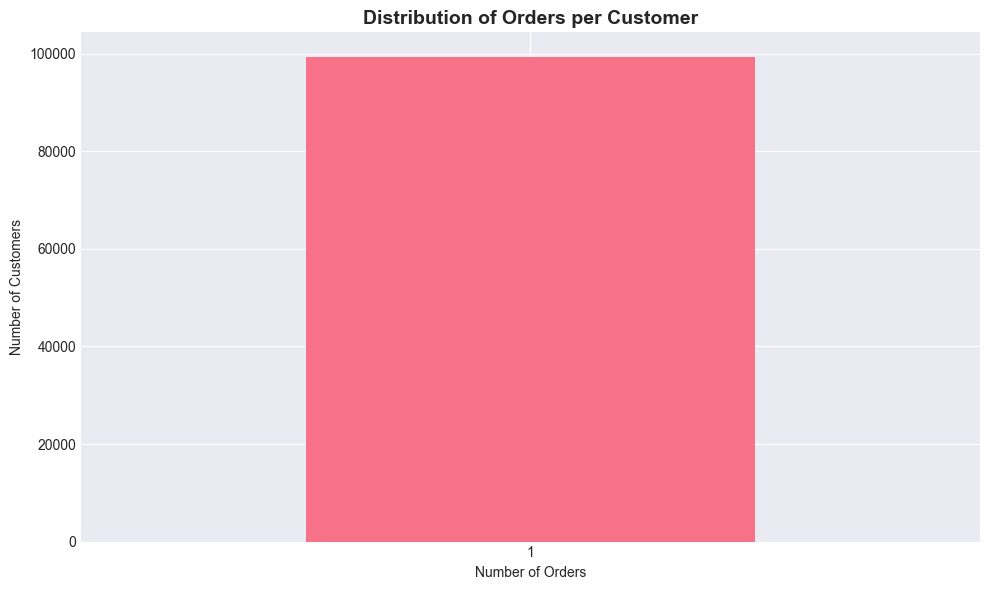

In [14]:
# Sipariş sayısı dağılımı
plt.figure(figsize=(10, 6))
customer_order_count['order_count'].value_counts().sort_index().head(10).plot(kind='bar')
plt.title('Distribution of Orders per Customer', fontsize=14, fontweight='bold')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
# Tek sipariş veren müşteri oranı
single_order_pct = (customer_order_count['order_count'] == 1).sum() / len(customer_order_count) * 100
print(f"\n⚠️  Customers with only 1 order: {single_order_pct:.2f}%")



⚠️  Customers with only 1 order: 100.00%


In [16]:
# =============================================================================
# 4. GELİR ANALİZİ
# =============================================================================

# Order items ile payments'ı birleştir
order_revenue = order_items.groupby('order_id')['price'].sum().reset_index()
order_revenue.columns = ['order_id', 'total_revenue']


In [17]:
# Orders ile birleştir
orders_with_revenue = orders.merge(order_revenue, on='order_id', how='left')


In [18]:
# Aylık gelir trendi
orders_with_revenue['order_month'] = orders_with_revenue['order_purchase_timestamp'].dt.to_period('M')
monthly_revenue = orders_with_revenue.groupby('order_month')['total_revenue'].sum()


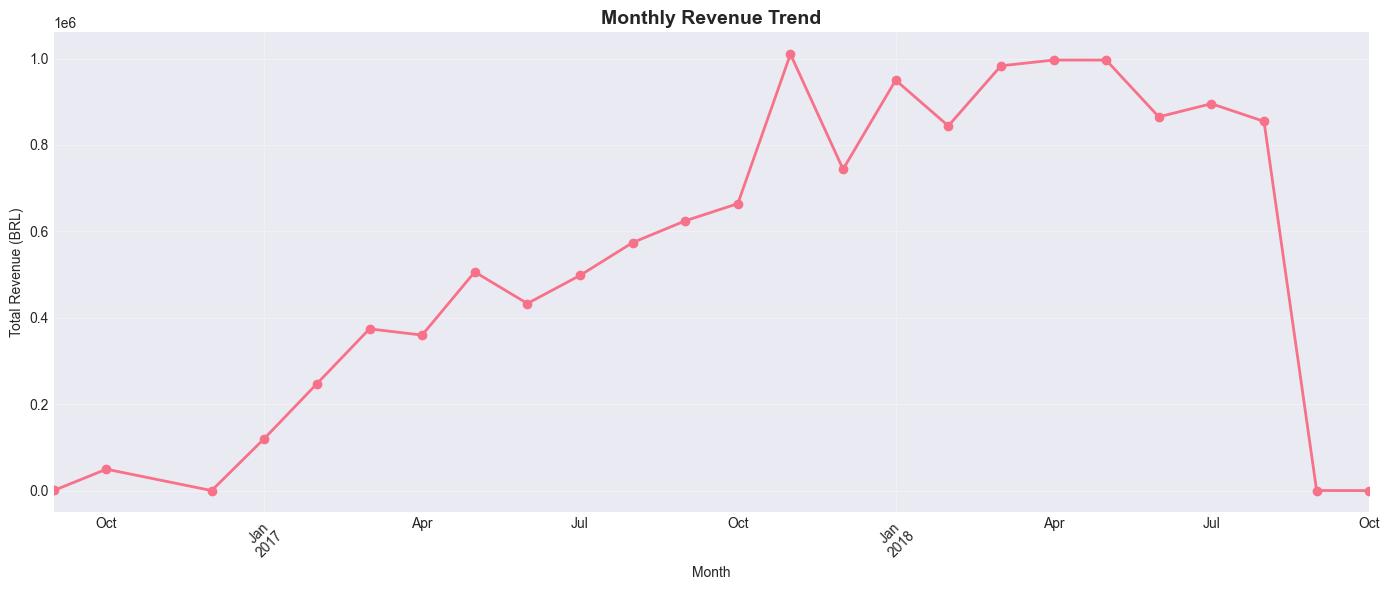

In [19]:
plt.figure(figsize=(14, 6))
monthly_revenue.plot(kind='line', marker='o', linewidth=2)
plt.title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Revenue (BRL)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# =============================================================================
# 5. CHURN TESPİTİ İÇİN ÖN HAZIRLIL
# =============================================================================

print("\n" + "="*80)
print("CHURN ANALYSIS PREPARATION")
print("="*80)

# Delivered orders ile çalışalım (completed transactions)
delivered_orders = orders[orders['order_status'] == 'delivered'].copy()
print(f"Total delivered orders: {len(delivered_orders)}")



CHURN ANALYSIS PREPARATION
Total delivered orders: 96478


In [22]:
# Her müşterinin ilk ve son sipariş tarihi
customer_first_last = delivered_orders.groupby('customer_id')['order_purchase_timestamp'].agg(['min', 'max'])
customer_first_last.columns = ['first_order_date', 'last_order_date']


In [23]:
# Müşteri başına sipariş sayısı
customer_order_freq = delivered_orders.groupby('customer_id').size().reset_index(name='total_orders')

# Analysis reference date (son sipariş tarihinden sonra)
ANALYSIS_DATE = delivered_orders['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
print(f"\nAnalysis reference date: {ANALYSIS_DATE}")


Analysis reference date: 2018-08-30 15:00:37


In [24]:
# Her müşteri için recency hesapla
customer_first_last['recency_days'] = (ANALYSIS_DATE - customer_first_last['last_order_date']).dt.days

# Churn tanımı: Son 180 günde sipariş vermemiş müşteriler
CHURN_THRESHOLD = 180
customer_first_last['is_churned'] = (customer_first_last['recency_days'] > CHURN_THRESHOLD).astype(int)

churn_rate = customer_first_last['is_churned'].mean() * 100
print(f"\n📊 Churn Rate (>{CHURN_THRESHOLD} days): {churn_rate:.2f}%")



📊 Churn Rate (>180 days): 59.82%


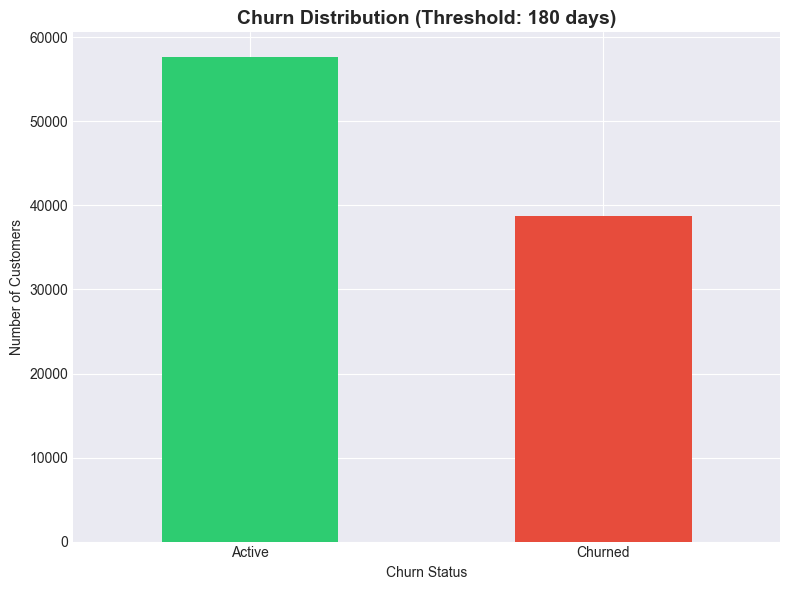

In [25]:
# Churn dağılımı
plt.figure(figsize=(8, 6))
customer_first_last['is_churned'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title(f'Churn Distribution (Threshold: {CHURN_THRESHOLD} days)', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Active', 'Churned'], rotation=0)
plt.tight_layout()
plt.show()